# Quick Start: Training IMDb sentiment model with ULMFiT. 

Really really good language models need to know a lot about the world. 

In [1]:
from fastai.text.all import *
from nlp_utils import *

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path

In [2]:
path = untar_data(URLs.IMDB_SAMPLE)

df = pd.read_csv(path/"texts.csv")
df.head()

,label,text,is_valid
0,negative,"Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!",False
1,positive,"This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is som...",False
2,negative,"Every once in a long while a movie will come along that will be so awful that I feel compelled to warn people. If I labor all my days and I can save but one soul from watching this movie, how great will be my joy.<br /><br />Where to begin my discussion of pain. For starters, there was a musical montage every five minutes. There was no character development. Every character was a stereotype. We had swearing guy, fat guy who eats donuts, goofy foreign guy, etc. The script felt as if it were being written as the movie was being shot. The production value was so incredibly low that it felt li...",False
3,positive,"Name just says it all. I watched this movie with my dad when it came out and having served in Korea he had great admiration for the man. The disappointing thing about this film is that it only concentrate on a short period of the man's life - interestingly enough the man's entire life would have made such an epic bio-pic that it is staggering to imagine the cost for production.<br /><br />Some posters elude to the flawed characteristics about the man, which are cheap shots. The theme of the movie ""Duty, Honor, Country"" are not just mere words blathered from the lips of a high-brassed offic...",False
4,negative,"This movie succeeds at being one of the most unique movies you've seen. However this comes from the fact that you can't make heads or tails of this mess. It almost seems as a series of challenges set up to determine whether or not you are willing to walk out of the movie and give up the money you just paid. If you don't want to feel slighted you'll sit through this horrible film and develop a real sense of pity for the actors involved, they've all seen better days, but then you realize they actually got paid quite a bit of money to do this and you'll lose pity for them just like you've alr...",False


In [3]:
dls_lm = TextDataLoaders.from_df(df, path=path, text_col="text", label_col="label",
                             valid_col="is_valid", is_lm=True, bs=64, 
                             num_workers=os.cpu_count())

/anaconda/envs/fastai/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


### Build and fine-tune a language model. 

In [4]:
torch.cuda.empty_cache()
torch.cuda.set_device(0)
learn = language_model_learner(dls_lm, AWD_LSTM, drop_mult=0.5,
                 metrics=[accuracy, Perplexity()], path=path)
learn.freeze()
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.218590,4.025110,0.276188,55.986481,00:21


In [5]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-4, 1e-2))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.919252,3.941983,0.278979,51.520687,00:27
1,3.753817,3.933550,0.279591,51.088001,00:27
2,3.457912,3.968305,0.281668,52.894817,00:27
3,3.179814,4.007241,0.280297,54.994946,00:27


Test language model 

In [6]:
def _predict(self, text, n_words=1, no_unk=True, temperature=1., min_p=None, no_bar=False,
                decoder=decode_spec_tokens, only_last_word=False):
        "Return `text` and the `n_words` that come after"
        self.model.reset()
        idxs = idxs_all = self.dls.test_dl([text]).items[0].to(self.dls.device)
        if no_unk: unk_idx = self.dls.vocab[0].index(UNK)
        for _ in (range(n_words) if no_bar else progress_bar(range(n_words), leave=False)):
            with self.no_bar(): preds,_ = self.get_preds(dl=[(idxs[None],)])
            res = preds[0][-1]
            if no_unk: res[unk_idx] = 0.
            if min_p is not None:
                if (res >= min_p).float().sum() == 0:
                    warn(f"There is no item with probability >= {min_p}, try a lower value.")
                else: res[res < min_p] = 0.
            if temperature != 1.: res.pow_(1 / temperature)
            idx = torch.multinomial(res, 1).item()
            idxs = idxs_all = torch.cat([idxs_all, idxs.new([idx])])
            if only_last_word: idxs = idxs[-1][None]

        num = self.dls.train_ds.numericalize
        tokens = [num.vocab[i] for i in idxs_all if num.vocab[i] not in [BOS, PAD]]
        sep = self.dls.train_ds.tokenizer.sep
        return sep.join(decoder(tokens))
    
learn.predict = _predict

In [7]:
learn.predict(learn, "This is a review about", n_words=10)

'This is a review about the horrors of war where Girlfriend did one lot'

In [8]:
learn.predict(learn, "In the hierarchy of horror movies this has to be near the top.",
                n_words=10)

'In the xxunk of horror movies this has to be near the top . a horror movie often uses the same term in a'

In [9]:
save_path = Path(os.getcwd())/"output"
if not os.path.exists(save_path): os.mkdir("output")
learn.save(save_path/"mini_imdb_lang_model")
learn.save_encoder(save_path/"mini_imdb_lang_model_enc")

## Build a movie review classifier. 

In [10]:
dls_clas = TextDataLoaders.from_df(df, path=path, text_col="text", label_col="label",
                             valid_col="is_valid", bs=64, num_workers=os.cpu_count(),
                             text_vocab=dls_lm.train_ds.vocab)

/anaconda/envs/fastai/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [11]:
torch.cuda.empty_cache()
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn.load_encoder(save_path/"mini_imdb_lang_model_enc")

In [12]:
dls_clas.show_batch()

,text,category
0,"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n\n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , xxunk bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj victor xxmaj vargas became i was always aware that something did n't quite feel right . xxmaj victor xxmaj vargas suffers from a certain xxunk on the director 's part . xxmaj apparently , the director thought that the ethnic backdrop of a xxmaj latino family on the lower east side , and an xxunk storyline would make the film critic proof . xxmaj he was right , but it did n't fool me . xxmaj raising xxmaj victor xxmaj vargas is",negative
1,"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the xxunk and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with the xxunk possible scenarios to get the two protagonists together in the end . xxmaj in fact , all its charm is xxunk , contained within the characters and the setting and the plot … which is highly believable to xxunk . xxmaj it 's easy to think that such a love story , as beautiful as any other ever told , * could * happen to you … a feeling you do n't often get from other romantic comedies",positive
2,"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj xxunk , after xxunk ) , i can xxunk join both xxunk of "" at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n\n xxmaj it 's usually satisfying to watch a film director change his style / subject , but xxmaj soderbergh 's most recent stinker , xxmaj the xxmaj girlfriend xxmaj xxunk ) , was also missing a story , so narrative ( and editing ? ) seem to suddenly be xxmaj soderbergh 's main challenge . xxmaj strange , after xxunk years in the business . xxmaj he was probably never much good at narrative , just xxunk it well inside "" edgy "" projects . \n\n xxmaj none of this excuses him this present , almost diabolical",negative
3,"xxbos xxmaj this film sat on my xxmaj xxunk for weeks before i watched it . i xxunk a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the screwed - up xxunk of xxmaj new xxmaj xxunk . \n\n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" la xxmaj xxunk , "" based on a play by xxmaj arthur xxmaj xxunk , who is given an "" inspired by "" credit . xxmaj it starts from one person , a prostitute , standing on a street corner in xxmaj brooklyn . xxmaj she is picked up by a home contractor , who has sex with her on the hood of a car , but ca n't come . xxmaj he refuses to pay her . xxmaj when he 's off xxunk , she",positive
4,"xxbos i really wanted to love this show . i truly , honestly did . \n\n xxmaj for the first time , gay viewers get their own version of the "" the xxmaj bachelor "" . xxmaj with the help of his obligatory "" hag "" xxmaj xxunk , xxmaj james , a good looking , well - to - do thirty - something has the chance of love with 15 suitors ( or "" mates "" as they are referred to in the show ) . xxmaj the only problem is half of them are straight and xxmaj james does n't know this . xxmaj if xxmaj james picks a gay one , they get a trip to xxmaj new xxmaj zealand , and xxmaj if he picks a straight one , straight guy gets $ 25 , xxrep 3 0 . xxmaj how can this not be fun",negative
5,"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first 3d game , or even the first xxunk - up . xxmaj it 's also one of the first xxunk games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - xxunk gami

SuggestedLRs(valley=tensor(0.0017))

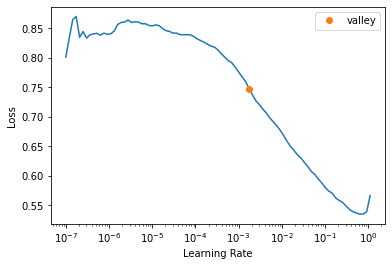

In [13]:
learn.lr_find()

In [14]:
learn.freeze()
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.557416,0.584571,0.755000,00:12


In [15]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-4, 1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.438638,0.501956,0.735000,00:27
1,0.348120,0.443583,0.800000,00:27
2,0.267885,0.521690,0.805000,00:27
3,0.200516,0.499075,0.810000,00:27


In [16]:
learn.predict("Although there was a lot of blood and violence, I didn't think this film " \
              "was scary enough.")

('positive', tensor(1), tensor([0.1742, 0.8258]))

In [17]:
learn.predict("Not so good World War II epic film.")

('positive', tensor(1), tensor([0.0982, 0.9018]))

There seems to be some problem with the model. It doesn't predict anything other than positive. 